#### Joshua Campos - Nr. 304738
### Lab Course Machine Learning
## Exercise 4

---------

We import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We read the data file and define the column names accordingly. Then we use the function .info() on the dataset to learn about it. 

In [2]:
columns = ['top-left','top-middle','top-right','middle-left','middle-middle',\
           'middle-right','bottom-left','bottom-middle','bottom-right','class']
file_name = 'tic-tac-toe.data'
dataset = pd.read_csv(file_name,names=columns)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
top-left         958 non-null object
top-middle       958 non-null object
top-right        958 non-null object
middle-left      958 non-null object
middle-middle    958 non-null object
middle-right     958 non-null object
bottom-left      958 non-null object
bottom-middle    958 non-null object
bottom-right     958 non-null object
class            958 non-null object
dtypes: object(10)
memory usage: 74.9+ KB


We see that the dataset has only non-numerical columns, so we use Pandas .get_dummies() function to convert all the categorical columns into numerical columns. During this conversion, we dropped the first column to avoid multicollinearity. After that, we use the function .info() again to see how the dataset is now structured. 

In [3]:
dataset_numerical = pd.get_dummies(dataset,drop_first=True)
dataset_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 19 columns):
top-left_o         958 non-null uint8
top-left_x         958 non-null uint8
top-middle_o       958 non-null uint8
top-middle_x       958 non-null uint8
top-right_o        958 non-null uint8
top-right_x        958 non-null uint8
middle-left_o      958 non-null uint8
middle-left_x      958 non-null uint8
middle-middle_o    958 non-null uint8
middle-middle_x    958 non-null uint8
middle-right_o     958 non-null uint8
middle-right_x     958 non-null uint8
bottom-left_o      958 non-null uint8
bottom-left_x      958 non-null uint8
bottom-middle_o    958 non-null uint8
bottom-middle_x    958 non-null uint8
bottom-right_o     958 non-null uint8
bottom-right_x     958 non-null uint8
class_positive     958 non-null uint8
dtypes: uint8(19)
memory usage: 17.9 KB


To see if the dataset is unbalanced, we perform a group by on the column that will be used as dependent variable, which in this case is 'class_positive'. We count the instances of each value and we can see that there are 332 negatives and 626 positives. With this small test, we can see that the data is indeed unbalanced. 

In [4]:
dataset_numerical.groupby('class_positive').count()['top-left_o']

class_positive
0    332
1    626
Name: top-left_o, dtype: int64

**Stratified Sampling:** It is when we divide the data into classes and then perform a random sample selection for each class, instead of doing it on the entire dataset. This method makes sure that every class has the same chance to have an equal participation on the train and test set. For example, if we have a large dataset and a small class and we choose to have an 80% for the train set, the small class may not be even considered into the train set or have a very small participation; but if we divide the data into the classes and then choose an 80% for the train set, an 80% of that small class will be included into the main train set. 

In the following function, we perform stratified sampling using the column 'class_positive' as the base and then we divide the train and test set for 80% and 20% respectively.

In [5]:
def perform_stratified_sampling(data,base_column,train_percentage):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    strata = data.groupby(base_column).count().index
    row_selection = np.random.rand(len(data)) < train_percentage
    for group in strata:
        group_set = data[data[base_column] == group]
        train_split = data[row_selection]
        train_data = train_data.append(train_split)
        test_split = data[~row_selection]
        test_data = test_data.append(test_split)
        break
    
    return (train_data,test_data)

base_column = 'class_positive'
train_percentage = 0.8
train_data,test_data = perform_stratified_sampling(dataset_numerical,base_column,train_percentage)

-----------

### Exercise 1: Logistic Regression with Gradient Ascent (10 points)

In order to start modeling, we need to split our data into the training sets and testing sets, as well as into our independent and dependent variables. For this exercise, we will be predicting the 'class_positive'. 

In [6]:
x_train = train_data.drop(base_column,axis=1)
y_train = np.array(train_data[base_column]).reshape(len(train_data[base_column]),1)

x_test = test_data.drop(base_column,axis=1)
y_test = test_data[base_column]

Next, we define the functions that we will be using and maximizing. The functions are the sigmoid function, the log loss function and its derivative. 

In [7]:
sigmoid_func = lambda X,beta: (1/(1+np.e**(-np.dot(X,beta))))
loss_func = lambda y,y_hat: np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))
loss_func_deriv = lambda X,y,y_hat: np.dot(X.T,y-y_hat)
loss_func_b = lambda X,y,beta: np.sum(np.dot(np.dot(X,beta).T,y)-np.log(1+np.e**np.dot(X,beta)))

Here we define the 'stepsize_bolddriver' algorithm and the 'learn_logreg_ga'. After defining our functions, we run our learning algorithm for 500 iterations using the bold driver algorithm to calculate the best step size, using 1.1 as increase factor and 0.5 as decrease factor. 

D:\Users\Joshua\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


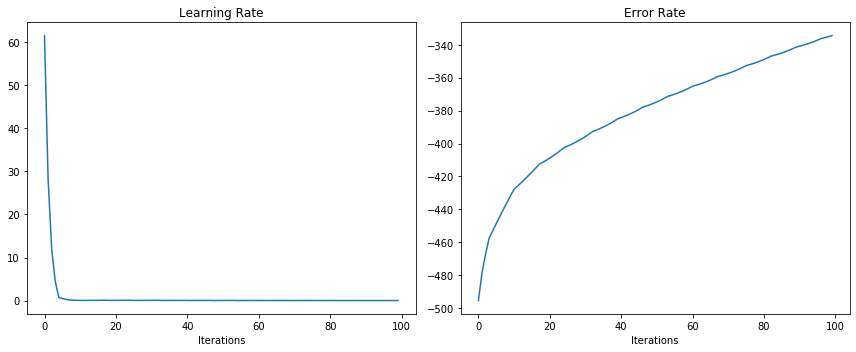

In [8]:
def stepsize_bolddriver(x,y,beta,step_size,increase_factor,decrease_factor):
    new_step_size = step_size*increase_factor
    gradient = np.sum(loss_func_deriv(x,y,beta.T))
    while np.sum(loss_func_b(x,y,beta) - loss_func_b(x,y,beta+new_step_size*gradient)) >= 0:
        new_step_size = new_step_size*decrease_factor
    return new_step_size

def learn_logreg_ga(x_train,y_train,step_size,max_iterations,increase_factor,decrease_factor):
    sigmoid_diff = []
    log_loss = []
    X = x_train
    y = y_train
    beta = np.zeros((X.shape[1],1))
    beta_old = beta
    y_hat = sigmoid_func(X,beta_old)
    sigmoid_old = np.sum(y_hat)
    for t in range(max_iterations):
        step_size = stepsize_bolddriver(X,y,beta_old,step_size,increase_factor,decrease_factor)
        gradient = loss_func_deriv(X,y,y_hat)
        beta_new = beta_old + step_size*gradient
        y_hat = sigmoid_func(X,beta_new)
        sigmoid_new = np.sum(y_hat)
        sigmoid_diff.append(abs(sigmoid_old-sigmoid_new))
        loss = loss_func(y,y_hat)
        log_loss.append(loss)
        beta_old = beta_new
        sigmoid_old = sigmoid_new
    return (beta_new,sigmoid_diff,log_loss)

step_size = 1
max_iterations = 100
increase_factor = 1.1
decrease_factor = 0.5

coefficients,sigmoid_diff,log_loss = learn_logreg_ga(x_train,y_train,step_size,max_iterations,increase_factor,decrease_factor)

plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
plt.plot(sigmoid_diff)
plt.title('Learning Rate')
plt.xlabel('Iterations')

plt.subplot(1,2,2)
plt.plot(log_loss)
plt.title('Error Rate')
plt.xlabel('Iterations')

plt.tight_layout()

In the graphs above, we can see that the Gradient Ascent algorithm converged really quickly, but the error rate didn't decrease to zero as quickly. We can see how the learning rate drops to zero almost immediately, while the error rate starts negatively and then starts to increase to get close to zero. This means that both the learning rate and error rate end up at zero.

--------------

### Exercise 2: Implement Newton Algorithm (Learning Rate) (10 Points)

Here, we define the 'learn_logreg_newton' function and then we run the algorithm with a step size of 0.1 for 100 iterations. In the algorithm, we calculate the coefficients, the function value difference against the last iteration and the logarithmic loss. 

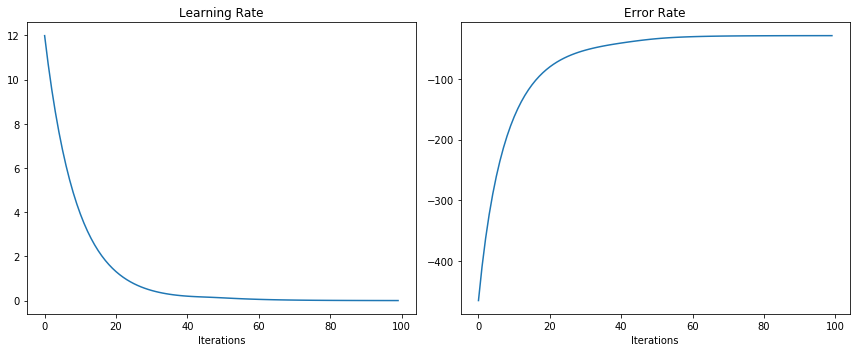

In [9]:
def learn_logreg_newton(x_train,y_train,learn_rate,max_iterations):
    sigmoid_diff = []
    log_loss = []
    X = x_train
    y = y_train
    beta_old = np.zeros((X.shape[1],1))
    y_hat = sigmoid_func(X,beta_old)
    sigmoid_old = np.sum(y_hat)
    for t in range(max_iterations):
        gradient = loss_func_deriv(X,y,y_hat)
        W = y_hat*(1-y_hat)
        WX = W*X
        hessian_matrix = np.linalg.inv(np.dot(X.T,WX))
        beta_new = beta_old + learn_rate*np.dot(hessian_matrix,gradient)
        y_hat = sigmoid_func(X,beta_new)
        sigmoid_new = np.sum(y_hat)
        sigmoid_diff.append(abs(sigmoid_old-sigmoid_new))
        loss = loss_func(y,y_hat)
        log_loss.append(loss)
        beta_old = beta_new
        sigmoid_old = sigmoid_new
    return (beta_new,sigmoid_diff,log_loss)

step_size = 0.1
max_iterations = 100
coefficients,differences,loss = learn_logreg_newton(x_train,y_train,step_size,max_iterations)

plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
plt.plot(differences)
plt.title('Learning Rate')
plt.xlabel('Iterations')

plt.subplot(1,2,2)
plt.plot(loss)
plt.title('Error Rate')
plt.xlabel('Iterations')

plt.tight_layout()

In the graphs above, we can see that the Newton Algorithm converged in less than 100 iterations. We can see how the learning rate starts to drop until it gets really close to zero while the error rate starts negatively and then starts to increase to get close to zero. This means that both the learning rate and error rate end up at zero.

**Final Comment:** By comparing the graphs from both algorithms, we can conclude that the Newton Algorithm did better minimizing the error rate in less than 100 iterations, however the Gradient Ascent Algorithm did better converging in less than 20 iterations.